# Project - DengAI

## Objective & Description

The goal of this project is to predict the number of dengue fever cases reported each week in San Juan (Puerto Rico) and Iquitos (Peru).

Useful links:
- https://www.cdc.gov/dengue/
- https://obamawhitehouse.archives.gov/blog/2015/06/05/back-future-using-historical-dengue-data-predict-next-epidemic
- http://dengueforecasting.noaa.gov


## Base Setup

In [153]:
import math

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import metrics
from matplotlib import pyplot as plt
from tensorflow.python.data import Dataset
import statsmodels.api as sm

In [154]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 30
tf.logging.set_verbosity(tf.logging.ERROR)

## Analysing the Dataset

### Importing data 

#### Importing training features

In [155]:
climate_variables_dataframe = pd.read_csv('../data/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv')
climate_variables_dataframe.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,...,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.40,20.00,16.00
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,...,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.70,22.20,8.60
2,sj,1990,20,1990-05-14,0.03,0.17,0.16,0.17,34.54,298.78,...,26.10,82.05,34.54,16.85,2.30,26.71,6.49,32.20,22.80,41.40
3,sj,1990,21,1990-05-21,0.13,0.25,0.23,0.24,15.36,298.99,...,13.90,80.34,15.36,16.67,2.43,27.47,6.77,33.30,23.30,4.00
4,sj,1990,22,1990-05-28,0.20,0.26,0.25,0.25,7.52,299.52,...,12.20,80.46,7.52,17.21,3.01,28.94,9.37,35.00,23.90,5.80


#### Importing training labels 

In [156]:
labels_dataframe = pd.read_csv('../data/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv')
labels_dataframe

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
5,sj,1990,23,2
6,sj,1990,24,4
7,sj,1990,25,5
8,sj,1990,26,10
9,sj,1990,27,6


### Descriptive statistics 

In [157]:
climate_variables_dataframe.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.00,1456.00,1262.00,1404.00,1434.00,1434.00,1443.00,1446.00,1446.00,1446.00,...,1446.00,1446.00,1443.00,1446.00,1446.00,1413.00,1413.00,1436.00,1442.00,1434.00
mean,2001.03,26.50,0.14,0.13,0.20,0.20,45.76,298.70,299.23,295.25,...,40.15,82.16,45.76,16.75,4.90,27.19,8.06,32.45,22.10,39.33
std,5.41,15.02,0.14,0.12,0.07,0.08,43.72,1.36,1.26,1.53,...,43.43,7.15,43.72,1.54,3.55,1.29,2.13,1.96,1.57,47.46
min,1990.00,1.00,-0.41,-0.46,-0.02,-0.06,0.00,294.64,294.89,289.64,...,0.00,57.79,0.00,11.72,1.36,21.40,4.53,26.70,14.70,0.00
25%,1997.00,13.75,0.04,0.05,0.16,0.14,9.80,297.66,298.26,294.12,...,13.05,77.18,9.80,15.56,2.33,26.30,6.51,31.10,21.10,8.70
50%,2002.00,26.50,0.13,0.12,0.20,0.19,38.34,298.65,299.29,295.64,...,27.24,80.30,38.34,17.09,2.86,27.41,7.30,32.80,22.20,23.85
75%,2005.00,39.25,0.25,0.22,0.25,0.25,70.23,299.83,300.21,296.46,...,52.20,86.36,70.23,17.98,7.62,28.16,9.57,33.90,23.30,53.90
max,2010.00,53.00,0.51,0.45,0.54,0.55,390.60,302.20,302.93,298.45,...,570.50,98.61,390.60,20.46,16.03,30.80,15.80,42.20,25.60,543.30


- Inequal count of examples (data debugging is needed)
- Different absolute values (some form of normalization is needed)
- Temperature values seem to be approximately normally distributed
- Diurnal temperature values and precipitation may be positively skewed (mean > median)
- Precipitation variables seem to also contain outliers

In [158]:
labels_dataframe.describe()

,year,weekofyear,total_cases
count,1456.00,1456.00,1456.00
mean,2001.03,26.50,24.68
std,5.41,15.02,43.60
min,1990.00,1.00,0.00
25%,1997.00,13.75,5.00
50%,2002.00,26.50,12.00
75%,2005.00,39.25,28.00
max,2010.00,53.00,461.00


- distribution may be positively skewed (mean > median)
- seems to have some outliers (max 461 when std equal 44)

### Histograms

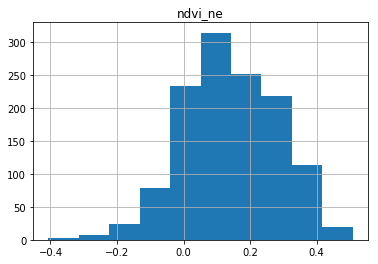

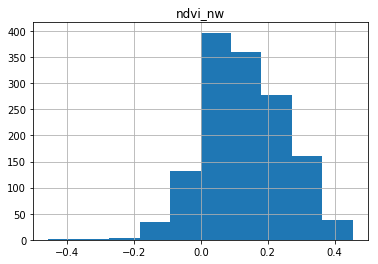

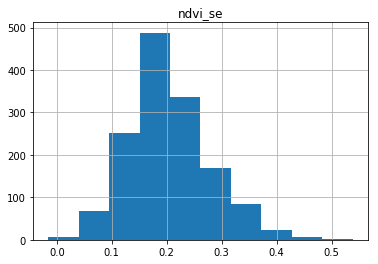

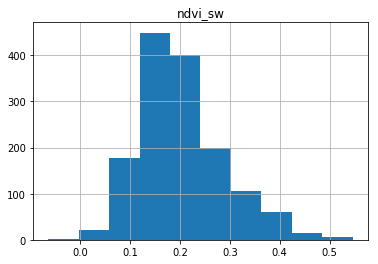

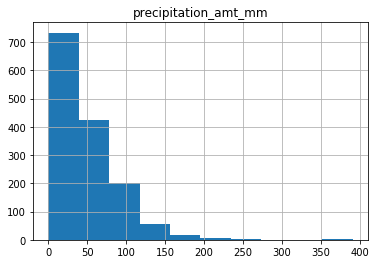

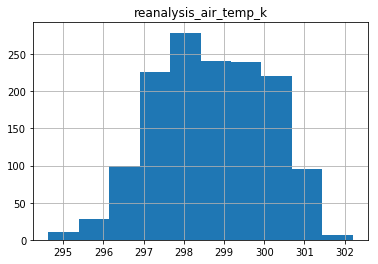

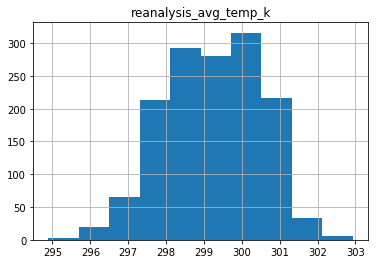

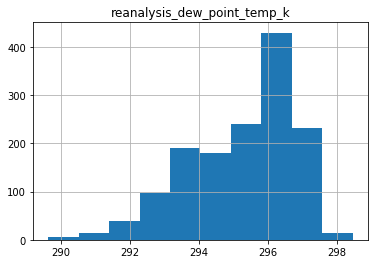

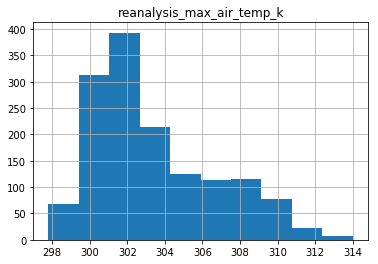

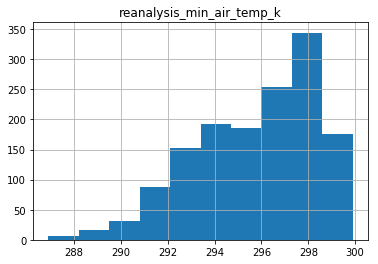

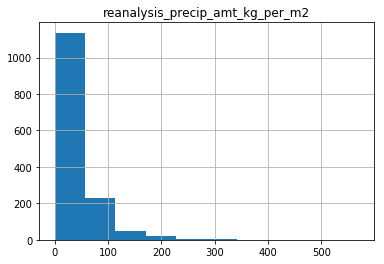

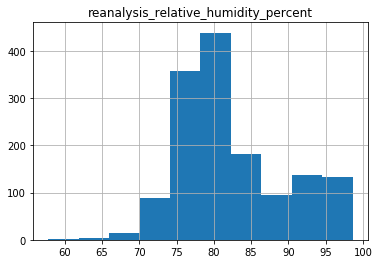

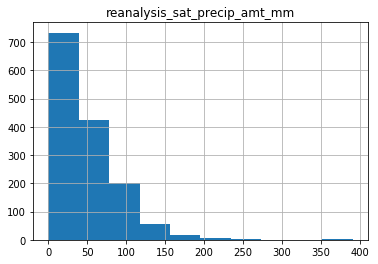

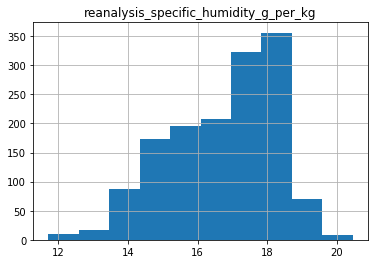

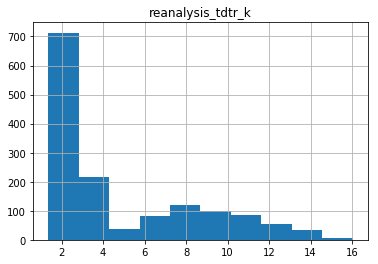

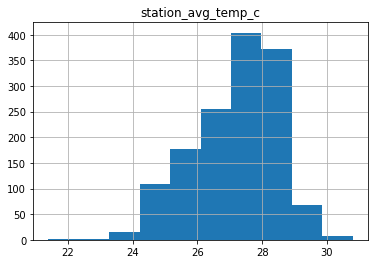

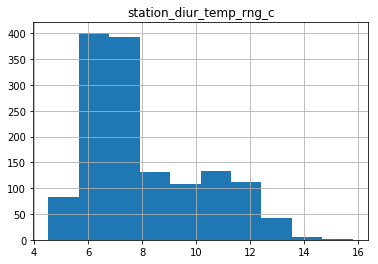

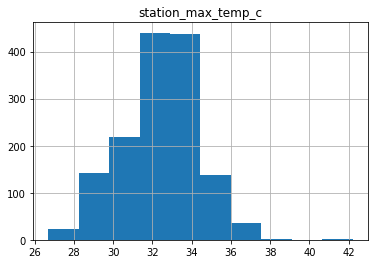

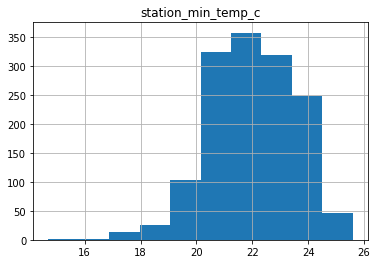

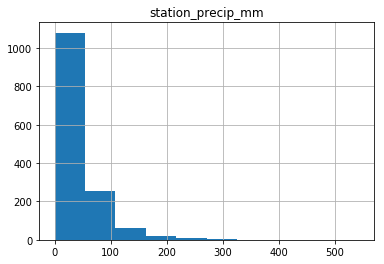

In [159]:
for key in climate_variables_dataframe:
    if key not in ['city', 'year', 'weekofyear', 'week_start_date']:
        climate_variables_dataframe.hist(key)

- `reanalysis_relative_humidity_percent` as a percentage value is bounded between 0% and 100%
- the skeweness of precitipation and diurnal temp variables is confirmed
- the `reanalysis_dew_point_temp_k` seems to be relatively negatively skewed, same goes for `reanalysis_min_air_temp_k`. `reanalysis_max_air_temp_k` seems to be positively skewed. The `station` min/max variables seem to point to the same.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1256bce48>]],
      dtype=object)

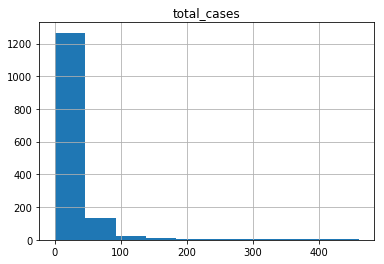

In [160]:
labels_dataframe.hist('total_cases')

- confirmed the suspected issues from the desriptive statistics

In [161]:
labels_dataframe['total_cases'].sort_values().tail(15)

429    256
431    263
228    272
239    288
229    302
430    329
234    333
235    353
238    359
237    364
233    381
230    395
236    410
231    426
232    461
Name: total_cases, dtype: int64

### Debugging data

#### Checking for mislabeling

In [162]:
climate_variables_dataframe['year'].unique().size

21

There are 21 years of data in the training set.

In [163]:
climate_variables_dataframe['city'].value_counts()

sj    936
iq    520
Name: city, dtype: int64

The count of examples for each city is not equal.

In [164]:
def count_for_city(city, feature):
    city_data = climate_variables_dataframe.where(climate_variables_dataframe['city'] == city)
    return city_data[feature].value_counts().sort_index()

In [165]:
count_for_city('sj', 'year')

1990.00    35
1991.00    52
1992.00    52
1993.00    52
1994.00    52
1995.00    52
1996.00    52
1997.00    52
1998.00    52
1999.00    52
2000.00    52
2001.00    52
2002.00    52
2003.00    52
2004.00    52
2005.00    52
2006.00    52
2007.00    52
2008.00    17
Name: year, dtype: int64

The data for San Juan starts from 1990 and spans until the first 17 weeks of 2008.

In [166]:
count_for_city('iq', 'year')

2000.00    26
2001.00    52
2002.00    52
2003.00    52
2004.00    52
2005.00    52
2006.00    52
2007.00    52
2008.00    52
2009.00    52
2010.00    26
Name: year, dtype: int64

The data for Iquitos starts from the second half of the year 2000 and end with the end of the first half of 2010.

In [167]:
NUMBER_OF_TOTAL_YEARS_SJ = 18
years_of_weeks_sj = count_for_city('sj', 'weekofyear')
years_of_weeks_sj[years_of_weeks_sj != NUMBER_OF_TOTAL_YEARS_SJ]

52.00    15
53.00     3
Name: weekofyear, dtype: int64

In [168]:
NUMBER_OF_TOTAL_YEARS_IQ = 10
years_of_weeks_iq = count_for_city('iq', 'weekofyear')
years_of_weeks_iq[years_of_weeks_iq != NUMBER_OF_TOTAL_YEARS_IQ]

52.00    8
53.00    2
Name: weekofyear, dtype: int64

In [169]:
climate_variables_dataframe[climate_variables_dataframe['weekofyear'] == 53]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
139,sj,1993,53,1993-01-01,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
451,sj,1999,53,1999-01-01,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
763,sj,2005,53,2005-01-01,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1170,iq,2005,53,2005-01-01,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1430,iq,2010,53,2010-01-01,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


The data for both cities has a week number equal to  "53" which seems to improper. The data climate variables for those examples are all NaN's.

In [170]:
labels_dataframe.shape == labels_dataframe.dropna().shape

True

The labels of the training data do not contain any erroneous data,

#### Removing missing values

In [171]:
climate_variables_dataframe_clean = climate_variables_dataframe.dropna()
climate_variables_dataframe_clean.shape

(1199, 24)

In [172]:
labels_dataframe_clean = labels_dataframe.reindex(climate_variables_dataframe_clean.index)
labels_dataframe_clean.shape

(1199, 4)

### Correlation Analysis

In [173]:
correlation_dataframe = climate_variables_dataframe_clean.copy()
correlation_dataframe = correlation_dataframe.drop(columns=['year', 'weekofyear'])
correlation_dataframe['target'] = labels_dataframe_clean['total_cases']

correlation_dataframe.corr()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,target
ndvi_ne,1.00,0.85,0.61,0.66,0.21,-0.34,-0.04,0.06,0.63,-0.62,...,0.47,0.21,0.10,0.67,0.19,0.66,0.49,-0.31,0.25,-0.24
ndvi_nw,0.85,1.00,0.57,0.66,0.21,-0.32,-0.03,0.08,0.61,-0.59,...,0.46,0.21,0.12,0.65,0.20,0.66,0.50,-0.31,0.24,-0.21
ndvi_se,0.61,0.57,1.00,0.82,0.09,-0.16,0.06,0.01,0.48,-0.42,...,0.22,0.09,0.04,0.50,0.09,0.46,0.30,-0.26,0.15,-0.18
ndvi_sw,0.66,0.66,0.82,1.00,0.13,-0.23,0.03,0.03,0.55,-0.50,...,0.31,0.13,0.06,0.57,0.12,0.55,0.39,-0.30,0.18,-0.21
precipitation_amt_mm,0.21,0.21,0.09,0.13,1.00,-0.06,0.08,0.41,0.29,-0.15,...,0.50,1.00,0.43,0.22,0.22,0.21,0.30,0.05,0.46,-0.04
reanalysis_air_temp_k,-0.34,-0.32,-0.16,-0.23,-0.06,1.00,0.90,0.50,-0.02,0.73,...,-0.44,-0.06,0.48,-0.28,0.60,-0.27,0.20,0.71,-0.20,0.34
reanalysis_avg_temp_k,-0.04,-0.03,0.06,0.03,0.08,0.90,1.00,0.59,0.39,0.43,...,-0.19,0.08,0.59,0.13,0.73,0.11,0.49,0.56,-0.07,0.19
reanalysis_dew_point_temp_k,0.06,0.08,0.01,0.03,0.41,0.50,0.59,1.00,0.25,0.34,...,0.55,0.41,1.00,-0.02,0.72,0.04,0.48,0.63,0.23,0.18
reanalysis_max_air_temp_k,0.63,0.61,0.48,0.55,0.29,-0.02,0.39,0.25,1.00,-0.61,...,0.40,0.29,0.29,0.92,0.45,0.84,0.77,-0.22,0.25,-0.24
reanalysis_min_air_temp_k,-0.62,-0.59,-0.42,-0.50,-0.15,0.73,0.43,0.34,-0.61,1.00,...,-0.43,-0.15,0.30,-0.82,0.20,-0.72,-0.30,0.72,-0.26,0.40


- temperature variables have the largest correlation to the target
- ndvi's are highly correlated to each other which is reasonable considering they represents plots of land close to each other
- ndvi's are also correlated with min(negatively)/max/diur temp variables, a seem to not be correlated with avg temp and barely with precipitation
- precipitation_amt_mm and reanalysis_sat_precip_amt_mm are perfectly positively correlated with each other. Different feature name for the same feature?
- reanalysis_air_temp_k and reanalysis_avg_temp_k highly correlated with each other in the 0.9 - 1 range
- reanalysis_specific_humidity_g_per_kg perfect correlation with reanalysis_dew_point_temp_k, as a higher dew point means there will be more moisture in the air
- min/max and diurnal temperature ranges are correlated through the former being variables in the calculation of the latter
- features measuring similar values, temp, precipitation are closely correlated to each other

In [174]:
persiann_precipitation = climate_variables_dataframe_clean['precipitation_amt_mm']
noaa_precipitation = climate_variables_dataframe_clean['reanalysis_sat_precip_amt_mm']
(persiann_precipitation == noaa_precipitation).unique()

array([ True])

- precipitation_amt_mm and reanalysis_sat_precip_amt_mm contain the same information

### Scatterplots

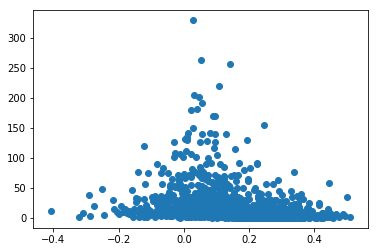

In [175]:
plt.scatter(climate_variables_dataframe_clean['ndvi_ne'], labels_dataframe_clean['total_cases'])

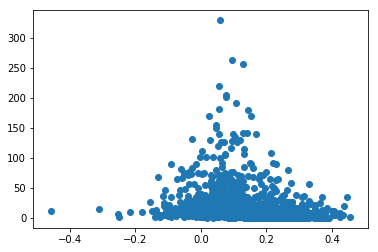

In [176]:
plt.scatter(climate_variables_dataframe_clean['ndvi_nw'], labels_dataframe_clean['total_cases'])

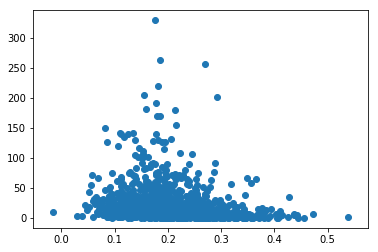

In [177]:
plt.scatter(climate_variables_dataframe_clean['ndvi_se'], labels_dataframe_clean['total_cases'])

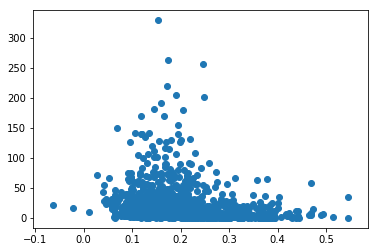

In [178]:
plt.scatter(climate_variables_dataframe_clean['ndvi_sw'], labels_dataframe_clean['total_cases'])

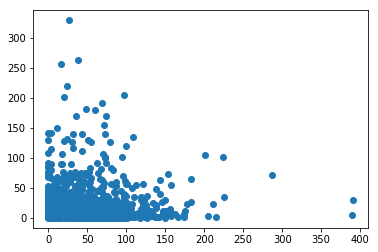

In [179]:
plt.scatter(climate_variables_dataframe_clean['precipitation_amt_mm'], labels_dataframe_clean['total_cases'])

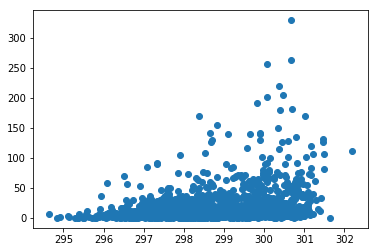

In [180]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_air_temp_k'], labels_dataframe_clean['total_cases'])

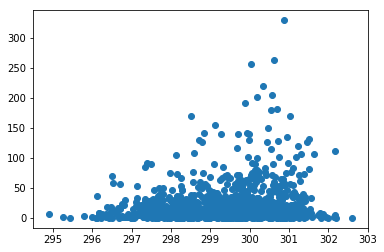

In [181]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_avg_temp_k'], labels_dataframe_clean['total_cases'])

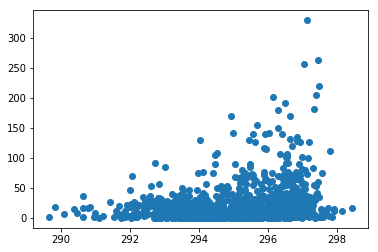

In [182]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_dew_point_temp_k'], labels_dataframe_clean['total_cases'])

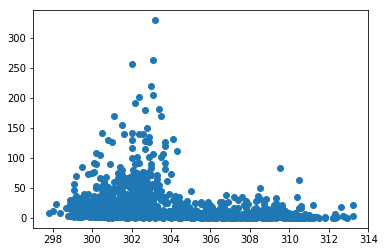

In [183]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_max_air_temp_k'], labels_dataframe_clean['total_cases'])

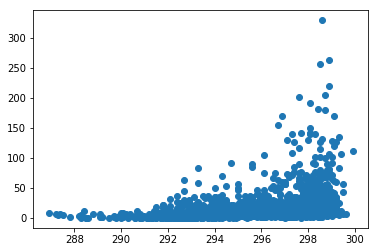

In [184]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_min_air_temp_k'], labels_dataframe_clean['total_cases'])

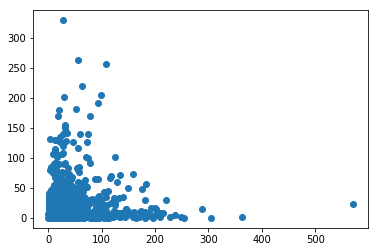

In [185]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_precip_amt_kg_per_m2'], labels_dataframe_clean['total_cases'])

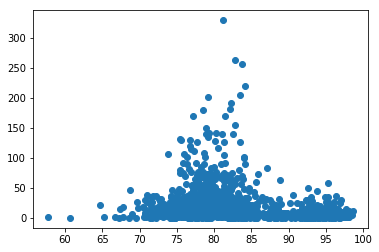

In [186]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_relative_humidity_percent'], labels_dataframe_clean['total_cases'])

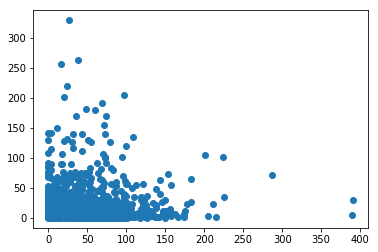

In [187]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_sat_precip_amt_mm'], labels_dataframe_clean['total_cases'])

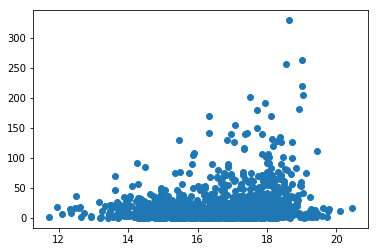

In [188]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_specific_humidity_g_per_kg'], labels_dataframe_clean['total_cases'])

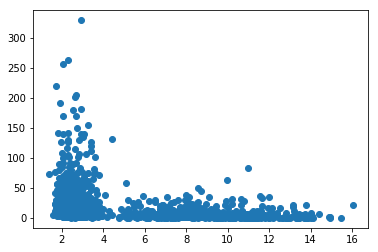

In [189]:
plt.scatter(climate_variables_dataframe_clean['reanalysis_tdtr_k'], labels_dataframe_clean['total_cases'])

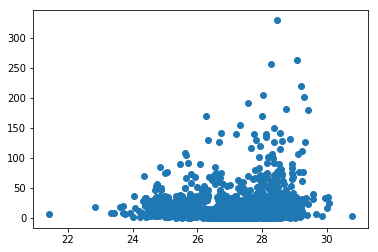

In [190]:
plt.scatter(climate_variables_dataframe_clean['station_avg_temp_c'], labels_dataframe_clean['total_cases'])

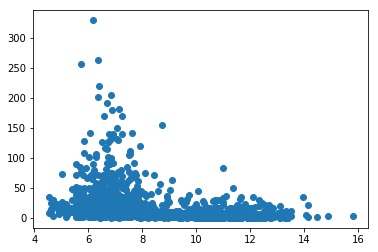

In [191]:
plt.scatter(climate_variables_dataframe_clean['station_diur_temp_rng_c'], labels_dataframe_clean['total_cases'])

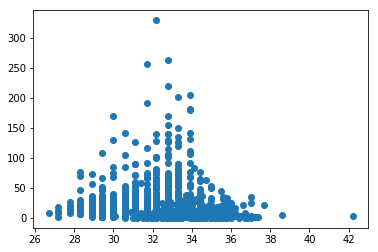

In [192]:
plt.scatter(climate_variables_dataframe_clean['station_max_temp_c'], labels_dataframe_clean['total_cases'])

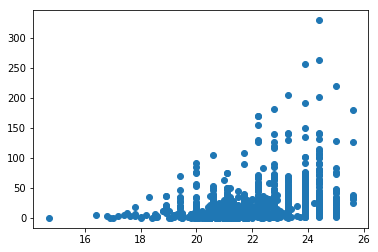

In [193]:
plt.scatter(climate_variables_dataframe_clean['station_min_temp_c'], labels_dataframe_clean['total_cases'])

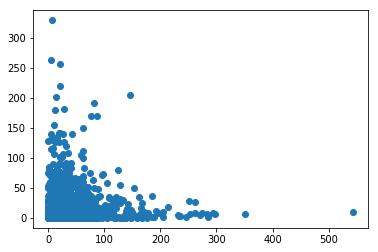

In [194]:
plt.scatter(climate_variables_dataframe_clean['station_precip_mm'], labels_dataframe_clean['total_cases'])

## Feature engineering

### Picking input features

- Removing reanalysis_sat_precip_amt_mm as it's the same data as precipitation_amt_mm
- Removing reanalysis_avg_temp as it is highly correlated with reanalysis_air_temp. reanalysis_air_temp has a higher correlation with the target
- Removing reanalysis_specific_humidity_g_per_kg as it's perfectly correlated with reanalysis_dew_point_temp_k
- As the diurnal temp range is function of the min/max temp will leave it out of the input features. Some previous studies were based on the diurnal temp and also analysis the specif effect of max and min temperatures.

In [195]:
climate_variables_dataframe_clean_filtered = climate_variables_dataframe_clean.drop(columns=['city', 'year', 'weekofyear', 'week_start_date', 'reanalysis_sat_precip_amt_mm', 'reanalysis_avg_temp_k', 'reanalysis_specific_humidity_g_per_kg', 'station_diur_temp_rng_c', 'reanalysis_tdtr_k'])
climate_variables_dataframe_clean_filtered.columns

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'station_avg_temp_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

### Normalizing features

In [196]:
def clip_outliers(series, min_value, max_value):
    return series.apply(lambda x: min(max(min_value, x), max_value))

def z_scale(series):
    mean = series.mean()
    std = series.std()
    return series.apply(lambda x: (x - mean) / std)

def bucketize(series, boundaries):
    bucketized_features = np.zeros((series.shape[0], len(boundaries) + 1), dtype='float64')
    
    for i, feature_value in enumerate(list(series)):
        for j, boundary in enumerate(boundaries):
            if feature_value < boundary:
                bucketized_features[i,j] = 1
                break

        if feature_value >= boundaries[-1]:
            bucketized_features[i, -1] = 1
    
    return np.transpose(bucketized_features)

In [197]:
NDVI_COLUMNS = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
NDVI_BOUNDARIES = np.linspace(-5, 5, 11) / 10

RELATIVE_VALUE_COLUMNS = ['reanalysis_relative_humidity_percent']
RV_BOUNDARIES = np.linspace(10, 90, 9)

BUCKETIZED_COLUMNS = NDVI_COLUMNS + RELATIVE_VALUE_COLUMNS

def normalize_features(samples_dataframe, bucketize=False):
    normalized_dataframe = samples_dataframe.copy()

    normalized_dataframe['precipitation_amt_mm'] = clip_outliers(normalized_dataframe['precipitation_amt_mm'], 0, 200)
    normalized_dataframe['reanalysis_precip_amt_kg_per_m2'] = clip_outliers(normalized_dataframe['reanalysis_precip_amt_kg_per_m2'], 0, 300)
    normalized_dataframe['station_precip_mm'] = clip_outliers(normalized_dataframe['station_precip_mm'], 0, 300)
    
    for column in normalized_dataframe:
        if column not in BUCKETIZED_COLUMNS:
            normalized_dataframe[column] = z_scale(normalized_dataframe[column])
    
    if bucketize:
        for column in NDVI_COLUMNS:
            bucketized_column = bucketize(normalized_dataframe[column], NDVI_BOUNDARIES)
            for bucket in zip(list(NDVI_BOUNDARIES) + ['higher'], bucketized_column):
                normalized_dataframe[f'{column}_{bucket[0]}'] = bucket[1]

        for column in RELATIVE_VALUE_COLUMNS:
            bucketized_column = bucketize(normalized_dataframe[column], RV_BOUNDARIES)
            for bucket in zip(list(RV_BOUNDARIES) + ['100'], bucketized_column):
                normalized_dataframe[f'{column}_{bucket[0]}'] = bucket[1]

        normalized_dataframe = normalized_dataframe.drop(BUCKETIZED_COLUMNS, axis=1)

    return normalized_dataframe

## Baseline

Using Poisson regession to estimate the weights of the model.

In [198]:
shuffled_index = np.random.permutation(climate_variables_dataframe_clean_filtered.index)
sample_examples = climate_variables_dataframe_clean_filtered.reindex(shuffled_index)
sample_labels = labels_dataframe_clean.reindex(shuffled_index)['total_cases']

training_examples = sample_examples.head(899)
training_targets = sample_labels.head(899)

validation_examples = sample_examples.tail(300)
validation_targets = sample_labels.tail(300)

In [199]:
def prepare_model_matrix(features):
    features = np.array([value for key, value in normalize_features(features).iterrows()])
    features = np.concatenate((np.zeros((features.shape[0], 1)) + 1, features), axis=1)
    return features

def prepare_response(targets):
    return np.array(targets).astype('float64')

In [200]:
y = prepare_response(training_targets)
x = prepare_model_matrix(training_examples)

w, linear_response, is_converged, num_iter = tfp.glm.fit(
    model_matrix=x,
    response=y,
    model=tfp.glm.Poisson()
)

log_likelihood = tfp.glm.Poisson().log_prob(y, linear_response)

with tf.Session() as sess:
    [w_, linear_response_, is_converged_, num_iter_, log_likelihood_] = sess.run([w, linear_response, is_converged, num_iter, log_likelihood])

y_predicted = np.exp(linear_response_)
likelihood = np.exp(log_likelihood_)

In [201]:
w_

array([ 3.03398872e+01, -4.00155215e-01,  1.31158496e+00, -4.82070173e-01,
       -4.42421986e-01, -2.89790304e-02, -1.85311646e+00,  2.50818689e+00,
       -1.46425940e-02,  2.18252833e-01,  1.40888096e-01, -3.32958430e-01,
        4.65636668e-02, -1.41147215e-01, -7.78486011e-02, -5.92474431e-02])

Comparing with statsmodels as double check.

In [202]:
statsmodels_model = sm.GLM(
    prepare_response(training_targets),
    prepare_model_matrix(training_examples),
    family=sm.families.family.Poisson(link=sm.genmod.families.links.log())
)

statsmodels_results = statsmodels_model.fit()
statsmodels_predictions = statsmodels_results.predict(prepare_model_matrix(training_examples))
statsmodels_likelihood = np.exp(
    sm.families.family.Poisson(link=sm.genmod.families.links.log()).loglike_obs(y, y_predicted)
)
statsmodels_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  899
Model:                            GLM   Df Residuals:                      883
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10743.
Date:                Sat, 04 May 2019   Deviance:                       17836.
Time:                        16:21:16   Pearson chi2:                 2.39e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.3399      2.627     11.549      0.000      25.191      35.489
x1            -0.4002      0.102     -3.921      0.000      -0.600      -0.200
x2             1.3116      0.115     11.423      0.000       1.087       1.537
x3            -0.4821      0.215     -2.242      0.025      -0.904      -0.061
x4            -0.4424      0.204     -2.169      0.030      -0.842      -0.043
x5            -0.0290      0.010     -3.002      0.003      -0.048      -0.010
x6            -1.8531      0.213     -8.691      0.000      -2.271      -1.435
x7             2.5082      0.232     10.808      0.000       2.053       2.963
x8            -0.0146      0.037     -0.396      0.692      -0.087       0.058
x9             0.2183      0.041      5.306      0.000       0.138       0.299
x10            0.1409      0.010     13.706      0.000       0.121       0.161
x11           -0.3330      0.032    -10.441      0.000      -0.395      -0.270
x12            0.0466      0.027      1.716      0.086      -0.007       0.100
x13           -0.1411      0.021     -6.866      0.000      -0.181      -0.101
x14           -0.0778      0.019     -4.173      0.000      -0.114      -0.041
x15           -0.0592      0.012     -4.972      0.000      -0.083      -0.036
==============================================================================
"""

In [203]:
pd.options.display.float_format = '{:.5f}'.format
likelihood = np.round(np.exp(log_likelihood_), 5)
results = pd.DataFrame(
    {
        'y': y,
        'y_pred': y_predicted,
        'likelihood': likelihood,
        'statsmodels_pred': statsmodels_predictions,
        'statsmodels_likelihood': statsmodels_likelihood
    }
)
results.sort_values('statsmodels_likelihood')

,y,y_pred,likelihood,statsmodels_pred,statsmodels_likelihood
791,329.00000,44.84619,0.00000,44.84619,0.00000
204,263.00000,51.18014,0.00000,51.18014,0.00000
683,256.00000,49.41641,0.00000,49.41641,0.00000
342,202.00000,30.70814,0.00000,30.70814,0.00000
598,220.00000,45.54331,0.00000,45.54331,0.00000
333,191.00000,40.70404,0.00000,40.70404,0.00000
29,181.00000,43.59304,0.00000,43.59304,0.00000
285,170.00000,40.55589,0.00000,40.55589,0.00000
575,83.00000,8.64556,0.00000,8.64556,0.00000
195,150.00000,33.47304,0.00000,33.47304,0.00000


Training MAE

In [204]:
metrics.mean_absolute_error(y, y_predicted)

16.242492577603908

#### Validation

In [205]:
y_predicted_validation = np.exp(np.dot(prepare_model_matrix(validation_examples), w_))
y_validation = prepare_response(validation_targets)
metrics.mean_absolute_error(y_validation, y_predicted_validation)

13.875078035131786

#### Distribution fit

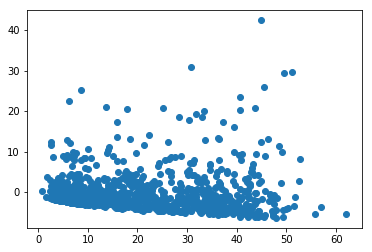

In [206]:
plt.scatter(statsmodels_results.mu, statsmodels_results.resid_pearson)
plt.show()

In [207]:
statsmodels_results.pearson_chi2 / statsmodels_results.df_resid

27.104413456491088

Significant overdispersion exists which means that the Poisson model is not an appropriate one for the data. Negative binomial model could be used 

## Model

Considering the problem at hand a Recurrent Network is used. Looking at the relevant time periods for the problem (EIP, mosqito development and life cycle) the sequence length choosen is equal 8 (representing 8 weeks).

In [208]:
observations = climate_variables_dataframe_clean_filtered
labels = labels_dataframe_clean['total_cases']

In [209]:
def build_sequences(observations, labels, sequence_size, step, delay):
    observations = np.array(observations)
    labels = np.array(labels)
    examples = []
    targets = []

    max_index = len(observations) - sequence_size - delay
    index = 0

    while index < max_index:
        examples.append(observations[index:index + sequence_size])
        targets.append(labels[index + sequence_size + delay])
        index += step

    return np.array(examples), np.array(targets)

In [210]:
def split_samples(examples, targets, sequence_size, step, split_ratio):
    total_sample = np.array(list(zip(examples, targets)))
    N = total_sample.shape[0]
    overlap = int(np.ceil(sequence_size / step) - 1)
    validation_sample_count = int(np.ceil(split_ratio * N / (1 + split_ratio * (1 + 2 * overlap))))
    
    validation_indices = list(np.random.choice(N, validation_sample_count, replace=False))
    validation_sample = total_sample[validation_indices]

    excluded_indices = set(validation_indices)

    for i in range(overlap):
        excluded_higher_indices = map(lambda x: min(N - 1, x + (i + 1)), validation_indices)
        excluded_lower_indices = map(lambda x: max(0, x - (i + 1)), validation_indices)
        excluded_indices = excluded_indices | set(excluded_higher_indices) | set(excluded_lower_indices)

    training_indices = list(set(range(N)) - excluded_indices)
    training_sample = total_sample[training_indices]

    training_examples, training_targets = zip(*list(training_sample))
    validation_examples, validation_targets = zip(*list(validation_sample))
    
    return map(np.asarray, (training_examples, training_targets, validation_examples, validation_targets))

In [211]:
from keras.utils import Sequence

class BatchGenerator(Sequence):
    def __init__(self, examples, targets, batch_size):
        self._examples = examples
        self._targets = targets
        self._batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self._examples) / self._batch_size))
    
    def __getitem__(self, index):
        start = index * self._batch_size
        end = index * self._batch_size + self._batch_size
        return self._examples[start:end], self._targets[start:end]

In [212]:
BATCH_SIZE = 32
SEQUENCE_SIZE = 8
STEP = 4
DELAY = 0
VALIDATION_TRAINING_SPLIT_RATIO = 0.1

examples, targets = build_sequences(
    normalize_features(observations),
    labels,
    sequence_size=SEQUENCE_SIZE,
    step=STEP,
    delay=DELAY
)

training_examples, training_targets, validation_examples, validation_targets = split_samples(
    examples,
    targets,
    sequence_size=SEQUENCE_SIZE,
    step=STEP,
    split_ratio=VALIDATION_TRAINING_SPLIT_RATIO
)

training_generator = BatchGenerator(training_examples, training_targets, BATCH_SIZE)
validation_generator = BatchGenerator(validation_examples, validation_targets, BATCH_SIZE)

In [213]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(32,input_shape=(SEQUENCE_SIZE, examples.shape[-1],), activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1, activation='exponential'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8, 32)             6144      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 14,497
Trainable params: 14,497
Non-trainable params: 0
_________________________________________________________________


In [214]:
model.compile(optimizer=RMSprop(), loss='poisson')

In [215]:
history = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    epochs=200
)

Epoch 1/200
8/8 [==============================] - 2s 217ms/step - loss: -12.9641 - val_loss: -27.2005
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: -38.8906 - val_loss: -34.7982
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: -40.7759 - val_loss: -38.4185
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: -39.1814 - val_loss: -32.4049
Epoch 5/200
8/8 [==============================] - 0s 25ms/step - loss: -39.3119 - val_loss: -34.8741
Epoch 6/200
8/8 [==============================] - 0s 14ms/step - loss: -39.2410 - val_loss: -39.1385
Epoch 7/200
8/8 [==============================] - 0s 24ms/step - loss: -42.0428 - val_loss: -41.3823
Epoch 8/200
8/8 [==============================] - 0s 14ms/step - loss: -39.1456 - val_loss: -38.4704
Epoch 9/200
8/8 [==============================] - 0s 25ms/step - loss: -42.7426 - val_loss: -38.7836
Epoch 10/200
8/8 [==============================] - 0s 13ms/step - loss: -39.4200

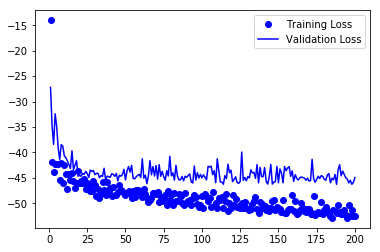

In [216]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.show()

In [217]:
predictions = model.predict_generator(validation_generator)
predictions = [np.round(prediction)[0] for prediction in predictions]
metrics.mean_absolute_error(validation_targets, predictions)

12.043478260869565